In [26]:
from pathlib import Path
from time import time as now
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from imageio import imread, imsave
import cv2
import dlclib
import deeplabcut as dlc

%matplotlib inline

In [2]:
videoroot = Path("../videos/train_2020-09-05")
annoroot  = Path("../tests/labeled-frames")
scaleroot = Path("../tests/labeled-frames-scaled")

## Frame extraction

In [3]:
def animal_name(path):
    name = path.stem
    bar  = name.index("_")
    return name[:bar]

In [4]:
animals = ("S005-19", "S006-19", "MLA-041630")

In [6]:
def extract_frames(path, destdir=annoroot, n_picked=20, digits=6):
    print(f"from {path.name}: loading...", end="", flush=True)
    frames = np.load(str(path))["frames"]
    print("resizing...", end="", flush=True)
    data = []
    for idx in range(frames.shape[0]):
        data.append(cv2.resize(frames[idx], (320, 240)))
    data = np.stack(data, axis=0)
    print("clustering...", end="", flush=True)
    anno   = MiniBatchKMeans(n_clusters=n_picked).fit_predict(data.reshape((data.shape[0], -1)))
    print("saving...", end="", flush=True)
    for clu in set(anno):
        indexes  = np.where(anno == clu)[0]
        picked   = np.random.randint(0, len(indexes))
        idx  = indexes[picked]
        dest = destdir / path.stem / f"frame{str(idx).zfill(digits)}.png"
        if not dest.parent.exists():
            dest.parent.mkdir(parents=True)
        imsave(str(dest), frames[idx])
    print("done.", flush=True)

In [8]:
for path in sorted(videoroot.glob("*.npz")):
    animal = animal_name(path)
    if animal in animals:
        extract_frames(path)

from MLA-041630_2020-09-05_run121738.npz: loading...resizing...clustering...saving...done.
from MLA-041630_2020-09-05_run121841.npz: loading...resizing...clustering...saving...done.
from MLA-041630_2020-09-05_run121942.npz: loading...resizing...clustering...saving...done.
from S005-19_2020-09-05_run124403.npz: loading...resizing...clustering...saving...done.
from S005-19_2020-09-05_run124440.npz: loading...resizing...clustering...saving...done.
from S005-19_2020-09-05_run124520.npz: loading...resizing...clustering...saving...done.
from S006-19_2020-09-05_run123918.npz: loading...resizing...clustering...saving...done.
from S006-19_2020-09-05_run123959.npz: loading...resizing...clustering...saving...done.
from S006-19_2020-09-05_run124103.npz: loading...resizing...clustering...saving...done.


## Scaling of images

In 8 bit images: $[0, 255]$ to $[15, 45]$

In [10]:
def scale_image(img_16b, low=15, high=45):
    """returns a 8-bit image"""
    conv = (((img_16b / 256) - low) / (high - low))
    conv[conv < 0] = 0
    conv[conv > 1] = 1
    return (conv * 255).astype(np.uint8)

In [12]:
img = imread("../tests/labeled-frames/S005-19_2020-09-05_run124403/frame000125.png")

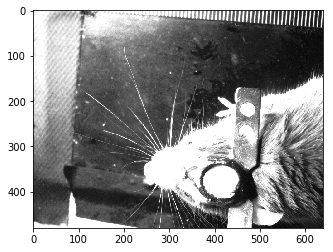

In [13]:
plt.imshow(scale_image(img), cmap=plt.get_cmap("Greys_r"), vmin=0, vmax=255)

In [14]:
for src_ani in sorted(annoroot.iterdir()):
    if not src_ani.is_dir():
        continue
    dst_ani = scaleroot / src_ani.name
    for src_img in sorted(src_ani.glob("*.png")):
        dst_img = dst_ani / src_img.name
        if not dst_img.parent.exists():
            dst_img.parent.mkdir(parents=True)
        imsave(str(dst_img), scale_image(imread(str(src_img))))

Annotation was performed using ImageJ

## Profiling

In [16]:
configs = {
    "S005-19": Path("../dlc_projects/S005-tips-Keisuke-2020-09-05/config.yaml").resolve(),
    "S006-19": Path("../dlc_projects/S006-tips-Keisuke-2020-09-07/config.yaml").resolve(),
    "MLA-041630": Path("../dlc_projects/MLA-041630-tips-Keisuke-2020-09-09/config.yaml").resolve()
}

In [53]:
WIDTHS = (10, 80, 160, 240, 320, 400, 480, 560, 640)

def profile_session(animalname, session, testdir, widths=WIDTHS, px_per_mm=8.72):
    manualpath = Path(testdir) / "coords.tsv"
    if not manualpath.exists():
        raise FileNotFoundError(f"'coords.tsv' not found in {testdir.name}")
    manual   = pd.read_csv(str(Path(testdir) / "coords.tsv"), sep="\t")
    names    = []
    subsample= []
    xpos     = []
    ypos     = []
    xann     = []
    yann     = []
    part     = []
    estimate = []
    
    shape    = None
    buf      = None
    reshaped = None
    rdims    = None
    factor   = None

    resize   = cv2.resize
    session.get_pose(np.empty((640,480,3), dtype=np.uint8)) # let GPU kernel warm-start
    
    for frame, imgpath in enumerate(sorted(p for p in testdir.glob("*.png"))):
        name = testdir.name + "_" + imgpath.stem
        img  = imread(str(imgpath)).astype(np.uint16) # emulate input format to be uint16

        if shape is None:
            # initialize parameters
            shape = img.shape
            reshaped = shape + (1,)
            buf      = np.empty(shape+(3,), dtype=np.uint8)
            
        buf[:] = (img/256).reshape(reshaped)
        
        for width in widths:
            
            if width != shape[1]:
                factor = shape[1]/width
                height = int(shape[0]/factor)
                rdims  = (width,height)
            else:
                rdims  = None
                factor = 1

            start  = now()
            if rdims is not None:
                pose   = session.get_pose(resize(buf, rdims, interpolation=cv2.INTER_NEAREST))
            else:
                pose   = session.get_pose(buf)
            end    = now()
            for ipart in range(pose.shape[0]):
                x_est = pose[ipart,0]*factor
                y_est = pose[ipart,1]*factor
                x_anno = manual.X[3*frame+ipart]
                y_anno = manual.Y[3*frame+ipart]
                names.append(name)
                subsample.append(width)
                part.append(ipart)
                xpos.append(x_est)
                ypos.append(y_est)
                xann.append(x_anno)
                yann.append(y_anno)
                estimate.append(np.nan if ipart>0 else (end-start))
    xpos = np.array(xpos)
    ypos = np.array(ypos)
    xann = np.array(xann)
    yann = np.array(yann)
    dev  = np.sqrt((xpos - xann)**2 + (ypos - yann)**2)
    
    return pd.DataFrame(data=dict(Animal=[animalname]*len(names),
                                  Image=names,
                                  Subsample_px=subsample,
                                  Part=part,
                                  X_anno=xann / px_per_mm,
                                  Y_anno=yann / px_per_mm, 
                                  X_pred=xpos / px_per_mm, 
                                  Y_pred=ypos / px_per_mm,
                                  Deviation=dev / px_per_mm,
                                  Latency=estimate))

In [19]:
TFSession = dlclib.estimate.TFSession

In [37]:
cfg = configs["S005-19"]
session = TFSession.from_config(cfg, locate_on_gpu=True)

Using /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S005-tips-Keisuke-2020-09-05/dlc-models/iteration-1/S005-tipsSep5-trainset95shuffle1/train/snapshot-1030000 for model /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S005-tips-Keisuke-2020-09-05/dlc-models/iteration-1/S005-tipsSep5-trainset95shuffle1
num_outputs =  1
Initializing ResNet
INFO:tensorflow:Restoring parameters from /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S005-tips-Keisuke-2020-09-05/dlc-models/iteration-1/S005-tipsSep5-trainset95shuffle1/train/snapshot-1030000


INFO:tensorflow:Restoring parameters from /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S005-tips-Keisuke-2020-09-05/dlc-models/iteration-1/S005-tipsSep5-trainset95shuffle1/train/snapshot-1030000


In [54]:
tables = []
dirfmt = "{name}_*"
for animal in sorted(configs.keys()):
    session = TFSession.from_config(configs[animal], locate_on_gpu=True)
    for testdir in sorted(annoroot.glob(dirfmt.format(name=animal))):
        print(f"running: {testdir.name}...", end="", flush=True)
        tables.append(profile_session(animal, session, testdir))
        print("done.")
merged = pd.concat(tables)

Using /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/MLA-041630-tips-Keisuke-2020-09-09/dlc-models/iteration-1/MLA-041630-tipsSep9-trainset95shuffle1/train/snapshot-1030000 for model /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/MLA-041630-tips-Keisuke-2020-09-09/dlc-models/iteration-1/MLA-041630-tipsSep9-trainset95shuffle1
num_outputs =  1
Initializing ResNet
INFO:tensorflow:Restoring parameters from /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/MLA-041630-tips-Keisuke-2020-09-09/dlc-models/iteration-1/MLA-041630-tipsSep9-trainset95shuffle1/train/snapshot-1030000


INFO:tensorflow:Restoring parameters from /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/MLA-041630-tips-Keisuke-2020-09-09/dlc-models/iteration-1/MLA-041630-tipsSep9-trainset95shuffle1/train/snapshot-1030000


running: MLA-041630_2020-09-05_run121738...done.
running: MLA-041630_2020-09-05_run121841...done.
running: MLA-041630_2020-09-05_run121942...done.
Using /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S005-tips-Keisuke-2020-09-05/dlc-models/iteration-1/S005-tipsSep5-trainset95shuffle1/train/snapshot-1030000 for model /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S005-tips-Keisuke-2020-09-05/dlc-models/iteration-1/S005-tipsSep5-trainset95shuffle1
num_outputs =  1
Initializing ResNet
INFO:tensorflow:Restoring parameters from /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S005-tips-Keisuke-2020-09-05/dlc-models/iteration-1/S005-tipsSep5-trainset95shuffle1/train/snapshot-1030000


INFO:tensorflow:Restoring parameters from /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S005-tips-Keisuke-2020-09-05/dlc-models/iteration-1/S005-tipsSep5-trainset95shuffle1/train/snapshot-1030000


running: S005-19_2020-09-05_run124403...done.
running: S005-19_2020-09-05_run124440...done.
running: S005-19_2020-09-05_run124520...done.
Using /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S006-tips-Keisuke-2020-09-07/dlc-models/iteration-1/S006-tipsSep7-trainset95shuffle1/train/snapshot-1030000 for model /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S006-tips-Keisuke-2020-09-07/dlc-models/iteration-1/S006-tipsSep7-trainset95shuffle1
num_outputs =  1
Initializing ResNet
INFO:tensorflow:Restoring parameters from /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S006-tips-Keisuke-2020-09-07/dlc-models/iteration-1/S006-tipsSep7-trainset95shuffle1/train/snapshot-1030000


INFO:tensorflow:Restoring parameters from /home/mouse/ks/Projects/whiskers-realtime/dlc_projects/S006-tips-Keisuke-2020-09-07/dlc-models/iteration-1/S006-tipsSep7-trainset95shuffle1/train/snapshot-1030000


running: S006-19_2020-09-05_run123918...done.
running: S006-19_2020-09-05_run123959...done.
running: S006-19_2020-09-05_run124103...done.


In [55]:
merged.head()

Animal                                        Image  Subsample_px  \
0  MLA-041630  MLA-041630_2020-09-05_run121738_frame000167            10   
1  MLA-041630  MLA-041630_2020-09-05_run121738_frame000167            10   
2  MLA-041630  MLA-041630_2020-09-05_run121738_frame000167            10   
3  MLA-041630  MLA-041630_2020-09-05_run121738_frame000167            80   
4  MLA-041630  MLA-041630_2020-09-05_run121738_frame000167            80   

   Part     X_anno     Y_anno     X_pred     Y_pred  Deviation   Latency  
0     0  34.403670  11.773739  26.060678  38.190525  27.702926  0.005150  
1     1  45.871560   9.938876  14.638042  46.016737  47.719437       NaN  
2     2  50.688073  11.085665  24.960107  57.567238  53.126875       NaN  
3     0  34.403670  11.773739   5.023658  58.184034  54.928140  0.004902  
4     1  45.871560   9.938876   4.104537  58.171991  63.803742       NaN

In [56]:
merged.to_csv("../profiling_data/profiling-frame-annotation.csv", index=False, header=True)

In [62]:
alpha = 5
latency = merged.groupby(["Subsample_px"]).agg(
    mean_ms=pd.NamedAgg(column="Latency", aggfunc=lambda values: np.nanmean(values)*1000),
    std_ms=pd.NamedAgg(column="Latency", aggfunc=lambda values: np.nanstd(values)*1000),
    median_ms=pd.NamedAgg(column="Latency", aggfunc=lambda values: np.nanmedian(values)*1000),
    lower_ms=pd.NamedAgg(column="Latency", aggfunc=lambda values: np.nanpercentile(values, alpha/2)*1000),
    upper_ms=pd.NamedAgg(column="Latency", aggfunc=lambda values: np.nanpercentile(values, 100-alpha/2)*1000)
)
latency

mean_ms    std_ms  median_ms   lower_ms   upper_ms
Subsample_px                                                      
10             6.430055  1.033394   6.493092   4.347724   8.341277
80             6.273692  1.031179   6.352544   4.354221   8.283639
160            6.668799  0.952479   6.723762   4.855174   8.328974
240            7.465666  1.085976   7.472873   5.325574   9.725088
320            8.083224  1.438565   7.856011   6.052393  12.397236
400            9.866638  1.839840   9.510040   7.702416  15.293729
480           11.114215  1.733747  10.564446   9.446007  16.810578
560           12.972216  1.390637  12.578368  11.446917  17.281127
640           15.392843  1.230318  15.159607  13.664925  18.339157

In [64]:
accuracy = merged.groupby(["Subsample_px"]).agg(
    mean_mm=pd.NamedAgg(column="Deviation", aggfunc=lambda values: np.nanmean(values)),
    std_mm=pd.NamedAgg(column="Deviation", aggfunc=lambda values: np.nanstd(values)),
    median_mm=pd.NamedAgg(column="Deviation", aggfunc=lambda values: np.nanmedian(values)),
    lower_mm=pd.NamedAgg(column="Deviation", aggfunc=lambda values: np.nanpercentile(values, alpha/2)),
    upper_mm=pd.NamedAgg(column="Deviation", aggfunc=lambda values: np.nanpercentile(values, 100-alpha/2))
)
accuracy

mean_mm     std_mm  median_mm   lower_mm   upper_mm
Subsample_px                                                       
10            40.201071  16.148102  36.776045   5.014546  68.208691
80            42.840615  15.544551  47.190147  13.330581  67.033342
160           21.162369  17.673171  18.205371   0.664390  55.796006
240            1.578684   3.420325   0.649698   0.083853   9.818834
320            1.395509   3.936289   0.480147   0.091430   7.544099
400            1.242824   3.708638   0.429932   0.076032   7.171122
480            1.361796   4.378298   0.470524   0.065180   7.351714
560            1.578295   5.136374   0.461341   0.071649  11.141607
640            1.621084   4.794471   0.472125   0.110215  12.599740

In [66]:
latency.to_csv("../profiling_data/profiling-frame-annotation-latencysummary.csv", header=True, index=True)
accuracy.to_csv("../profiling_data/profiling-frame-annotation-accuracysummary.csv", header=True, index=True)

## Figure generation

In [74]:
figdir = Path("../profiling_figs/profiling-DLC_2020-09-23")
if not figdir.exists():
    figdir.mkdir(parents=True)

def save_fig(fig, basename, dpi=600):
    basepath = figdir / basename
    fig.savefig(str(basepath.with_suffix(".png")), dpi=dpi)
    fig.savefig(str(basepath.with_suffix(".svg")))

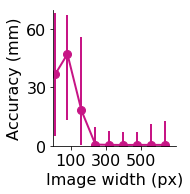

In [83]:
fmt   = "o-"

fig = plt.figure(figsize=(2.5,3))

plt.errorbar(accuracy.index, accuracy.median_mm, fmt=fmt, yerr=(accuracy.median_mm - accuracy.lower_mm,
                                                              accuracy.upper_mm - accuracy.median_mm),
             color="mediumvioletred", ms=8, lw=2)

plt.xlim(0, 700)
plt.ylim(0, 70)
plt.xticks((100, 300, 500))
plt.yticks((0, 30, 60))
plt.xlabel("Image width (px)", fontsize=16)
plt.ylabel("Accuracy (mm)", fontsize=16)
plt.tick_params(labelsize=16)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.subplots_adjust(bottom=.25, left=.28, right=.96)
save_fig(fig, "accuracy")

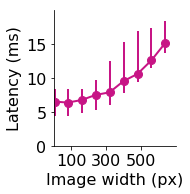

In [84]:
fig = plt.figure(figsize=(2.5,3))
plt.errorbar(latency.index, latency.median_ms, fmt="o-",
             yerr=(latency.median_ms - latency.lower_ms,
                   latency.upper_ms - latency.median_ms),
             color="mediumvioletred", ms=8, lw=2)
plt.xlim(0, 700)
plt.ylim(0, 20)
plt.xticks((100, 300, 500))
plt.yticks((0, 5, 10, 15))
plt.xlabel("Image width (px)", fontsize=16)
plt.ylabel("Latency (ms)", fontsize=16)
plt.tick_params(labelsize=16)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.subplots_adjust(bottom=.25, left=.28, right=.96)
save_fig(fig, "latency")